In [1]:
from data.conll import conll2003_dataset, extract_samples
from misc.preferences import PREFERENCES
from misc.visualizer import *
from misc.hyperparameters import get_default_params
from optimizer import get_default_optimizer
from misc import utils
from models.transformer.encoder import TransformerEncoder
from models.softmax_output import SoftmaxOutputLayer, OutputLayer
from models.transformer_tagger import TransformerTagger
from models.transformer.train import Trainer
from criterion import NllLoss

C:\Users\felix\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
experiment_name = '10_epoch_TestRun'

In [3]:
PREFERENCES.defaults(
    data_root='./data/conll2003',
    data_train='eng.train.txt',
    data_validation='eng.testa.txt',
    data_test='eng.testb.txt',
    early_stopping='highest_5_F1'
)

hyper_parameters = get_default_params()
hyper_parameters.model_size = 300
hyper_parameters.batch_size = 80
hyper_parameters.early_stopping = -1
experiment_name = utils.create_loggers(experiment_name=experiment_name)

Log path is  C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\logs\10_epoch_TestRun


In [4]:
conll2003 = conll2003_dataset('ner', hyper_parameters.batch_size,
                              root=PREFERENCES.data_root,
                              train_file=PREFERENCES.data_train,
                              validation_file=PREFERENCES.data_validation,
                              test_file=PREFERENCES.data_test,
                              use_cuda=True)



In [5]:
samples = extract_samples(conll2003['examples'])
print_samples(samples)

eu - I-ORG
rejects - O
german - I-MISC
call - O
to - O
boycott - O
british - I-MISC
lamb - O
. - O

#######################

peter - I-PER
blackburn - I-PER

#######################

brussels - I-LOC
1996-08-22 - O

#######################

cricket - O
- - O
leicestershire - I-ORG
take - O
over - O
at - O
top - O
after - O
innings - O
victory - O
. - O

#######################

london - I-LOC
1996-08-30 - O

#######################

west - I-MISC
indian - I-MISC
all-rounder - O
phil - I-PER
simmons - I-PER
took - O
four - O
for - O
0 - O
on - O
friday - O
as - O
leicestershire - I-ORG
beat - O
somerset - I-ORG
by - O
an - O
innings - O
and - O
0 - O
runs - O
in - O
two - O
days - O
to - O
take - O
over - O
at - O
the - O
head - O
of - O
the - O
county - O
championship - O
. - O

#######################

soccer - O
- - O
japan - I-LOC
get - O
lucky - O
win - O
, - O
china - I-PER
in - O
surprise - O
defeat - O
. - O

#######################

nadim - I-PER
ladki - I-PER

################

In [6]:
# 10 words with a 100-length embedding
target_vocab = conll2003['vocabs'][1]
target_size = len(target_vocab)
print('Targets:',target_vocab.freqs.keys())
print(target_vocab.freqs)

Targets: dict_keys(['I-ORG', 'O', 'I-MISC', 'I-PER', 'I-LOC', 'B-LOC', 'B-MISC', 'B-ORG'])
Counter({'O': 169578, 'I-PER': 11128, 'I-ORG': 10001, 'I-LOC': 8286, 'I-MISC': 4556, 'B-MISC': 37, 'B-ORG': 24, 'B-LOC': 11})


In [7]:
total_samples = 0
for l, freq in target_vocab.freqs.items():
    print('{}: {}'.format(l, freq))
    total_samples += freq
print('\nTotal Samples:',total_samples)

print('\n\nTrivial classifiers')
for l, freq in target_vocab.freqs.items():
    acc = float(freq) / float(total_samples)
    print('Trivial {}: {}%'.format(l, acc*100))

I-ORG: 10001
O: 169578
I-MISC: 4556
I-PER: 11128
I-LOC: 8286
B-LOC: 11
B-MISC: 37
B-ORG: 24

Total Samples: 203621


Trivial classifiers
Trivial I-ORG: 4.9115759180045275%
Trivial O: 83.2811939829389%
Trivial I-MISC: 2.2374902392189413%
Trivial I-PER: 5.4650551760378345%
Trivial I-LOC: 4.069324873171235%
Trivial B-LOC: 0.005402193290475934%
Trivial B-MISC: 0.01817101379523723%
Trivial B-ORG: 0.011786603542856582%


In [8]:
loss = NllLoss(target_size)
# transformer = GoogleTransformer(True, target_size, target_size, num_units, 2, 2, 512, 0.1)
transformer = TransformerEncoder(conll2003['embeddings'][0],
                                 n_enc_blocks=2,
                                 n_head=3,
                                 d_model=hyper_parameters.model_size,
                                 d_k=100,
                                 d_v=100)
tagging_softmax = SoftmaxOutputLayer(hyper_parameters.model_size, target_size)
model = TransformerTagger(transformer, tagging_softmax)


In [9]:
# predict now to see model in final state
#df = predict_some_examples_to_df(model, conll2003['iters'][1], num_samples=400)
#print(df)

In [10]:
optimizer = get_default_optimizer(model, hyper_parameters)
trainer = Trainer(target_size, 
                    model,
                    loss,
                    optimizer,
                    hyper_parameters,
                    conll2003['iters'],
                    experiment_name,
                    log_every_xth_iteration=-1,
                    enable_tensorboard=True,
                    dummy_input=conll2003['dummy_input'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1              [-1, 42, 300]       7,816,800
           Dropout-2              [-1, 42, 300]               0
PositionalEncoding2-3              [-1, 42, 300]               0
            Linear-4              [-1, 42, 300]          90,000
            Linear-5              [-1, 42, 300]          90,000
            Linear-6              [-1, 42, 300]          90,000
           Dropout-7               [-1, 42, 42]               0
ScaledDotProductAttentionLayer-8              [-1, 42, 100]               0
            Linear-9              [-1, 42, 300]          90,000
          Dropout-10              [-1, 42, 300]               0
        LayerNorm-11              [-1, 42, 300]               0
MultiHeadedSelfAttentionLayer-12              [-1, 42, 300]               0
           Linear-13             [-1, 42, 2048]         616,448
           Lin

In [11]:
plt.rcParams['figure.figsize'] = [10, 5]

In [12]:
result = trainer.train(10, True, False)

pre_training - DEBUG - train with cuda support
pre_training - INFO - 176 Iterations per epoch with batch size of 80
pre_training - INFO - START training.





A Jupyter Widget

# EP	# IT	tr loss		val loss	f1
0	176	0.748		0.714		0.771


A Jupyter Widget

1	352	0.114		0.349		0.889


A Jupyter Widget

2	528	0.055		0.261		0.920


A Jupyter Widget

3	704	0.034		0.247		0.924


A Jupyter Widget

4	880	0.025		0.250		0.925


A Jupyter Widget

5	1056	0.018		0.232		0.931


A Jupyter Widget

6	1232	0.014		0.231		0.939


A Jupyter Widget

7	1408	0.011		0.223		0.939


A Jupyter Widget

8	1584	0.009		0.280		0.929


A Jupyter Widget

9	1760	0.008		0.257		0.942


In [13]:
model = result['model']

In [14]:
print(result)

{'model': TransformerTagger(
  (encoder): TransformerEncoder(
    (src_embeddings): Embedding(26056, 300)
    (positional_encoding): PositionalEncoding2(
      (dropout): Dropout(p=0.1)
    )
    (encoder_blocks): ModuleList(
      (0): EncoderBlock(
        (self_attention_layer): MultiHeadedSelfAttentionLayer(
          (query_projections): Linear(in_features=300, out_features=300, bias=False)
          (key_projections): Linear(in_features=300, out_features=300, bias=False)
          (value_projections): Linear(in_features=300, out_features=300, bias=False)
          (attention_layer): ScaledDotProductAttentionLayer(
            (dropout): Dropout(p=0.1)
          )
          (layer_norm): LayerNorm()
          (w_0): Linear(in_features=300, out_features=300, bias=False)
          (dropout): Dropout(p=0.1)
        )
        (feed_forward_layer): PointWiseFCLayer(
          (layer_norm): LayerNorm()
          (w_1): Linear(in_features=300, out_features=2048, bias=True)
          (w_2

pre_training - INFO - Perform final model evaluation
pre_training - DEBUG - --- Train Scores ---


A Jupyter Widget


pre_training - INFO - TRAIN loss:	0.005887293187366926
pre_training - INFO - TRAIN f1-s:	0.9979743046719594
pre_training - INFO - TRAIN accuracy:	0.9980026400150858
pre_training - DEBUG - --- Valid Scores ---


A Jupyter Widget


pre_training - INFO - VALID loss:	0.2563207288118888
pre_training - INFO - VALID f1-s:	0.9431709270473017
pre_training - INFO - VALID accuracy:	0.9491063432109341


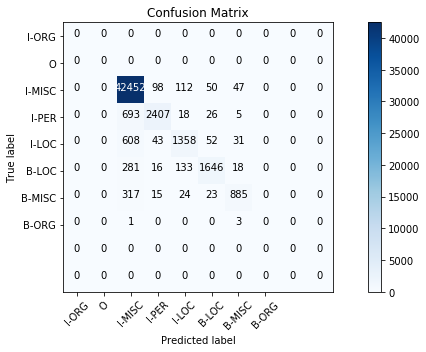

A Jupyter Widget


pre_training - INFO - TEST loss:	0.400073490190235
pre_training - INFO - TEST f1-s:	0.9008851938794048
pre_training - INFO - TEST accuracy:	0.9303192775941305


In [15]:
trainer.tb_writer = None
trainer.enable_tensorboard = False
evaluation_results = trainer.perform_final_evaluation()

In [20]:
# predict now to see model in final state
from IPython.display import display, HTML

df = predict_some_examples_to_df(model, conll2003['iters'][2], num_samples=800)
display(HTML(df.to_html()))

,Sentence,Targets,Predictions,# Matches
0,',O,O,1
1,men,O,O,1
2,women,O,O,1
3,pakistan,I-LOC,I-LOC,1
4,reuter,I-ORG,I-PER,0
5,australia,I-LOC,I-LOC,1
6,),O,O,1
7,amor,I-PER,I-PER,1
8,popescu,I-PER,O,0
9,josepguardiola,I-PER,O,0


In [21]:
df = predict_some_examples_to_df(model, conll2003['iters'][1], num_samples=800)
display(HTML(df.to_html()))

,Sentence,Targets,Predictions,# Matches
0,may,O,O,1
1,june,O,O,1
2,july,O,O,1
3,august,O,O,1
4,:,O,O,1
5,6-2,O,O,1
6,:,O,O,1
7,australia,I-LOC,I-LOC,1
8,1996-08-30,O,O,1
9,kompas,I-ORG,O,0


In [22]:
df = predict_some_examples_to_df(model, conll2003['iters'][0], num_samples=800)
display(HTML(df.to_html()))

,Sentence,Targets,Predictions,# Matches
0,thefactionsreachedaceasefireonfridayafteraweek...,OOOOOOOOOOOOOOOOOOOOOOOOOO,OOOOOOOOOOOOOOOOOOOOOOOOOO,26
1,"0jimfuryk,satoshihigashi(japan),williewood,shi...",OI-PERI-PEROI-PERI-PEROI-LOCOOI-PERI-PEROI-PER,OI-PERI-PEROI-PERI-PEROI-LOCOOI-PERI-PEROI-PER,14
2,soccer-brazilianchampionshipresults/standings.,OOI-MISCOOOOO,OOI-MISCOOOOO,8
3,theyreportedmorearrivalsthatwereprobablyspotpu...,OOOOOOOOOO,OOOOOOOOOO,10
4,yr/yrrise+3.5+3.6+5.2--,OOOOOOOOO,OOOOOOOOO,9
5,sinttruiden0ekeren0,I-ORGI-ORGOI-ORGO,I-ORGI-ORGOI-ORGO,5
6,lausanne0000000,I-ORGOOOOOOO,I-ORGOOOOOOO,8
7,benficadominatedthegamebuttheirlackofafirst-cl...,I-ORGOOOOOOOOOOOOOOOOOOOOOI-MISCOI-PEROOOOOOO,I-ORGOOOOOOOOOOOOOOOOOOOOOI-MISCOI-PEROOOOOOO,32
8,cricket-indiawintossandbatagainstsrilanka.,OOI-LOCOOOOOI-LOCI-LOCO,OOI-LOCOOOOOI-LOCI-LOCO,11
9,1.michaeljohnson(u.s.)44.29seconds,OI-PERI-PEROI-LOCOOO,OI-PERI-PEROI-LOCOOO,8


In [ ]:
import numpy as np
a = np.array([
    np.array([[1, 1], [1, 1]]),
    np.array([[2, 2], [-2, -3]])
])
print(a)

In [ ]:
a.sum(axis=0)

In [ ]:
#df = predict_some_examples_to_df(model, test_sample_iter)
#print(df)

In [ ]:
#print(result)

In [ ]:
(tr_loss, tr_f1) = result['result_train']
